In [233]:
import pandas as pd
import scipy.stats as ss
import pandahouse as ph
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from urllib.parse import urlencode 
import pingouin as pg

# Задача № 1. A/B–тестирование.

1.1 Условие

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.*

1.2 Входные данные

*В качестве входных данных вы имеете 4 csv-файла:*

* groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
* groups_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента.



* подгрузим данные и проведем "разведку" данных (EDA):

In [234]:
# создадим функцию подготовки ссылки для чтения файла с Яндекс диска
def url_from_yandex_disk(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' # используем api
    final_url = base_url + urlencode(dict(public_key=public_key)) # получаем url 
    response = requests.get(final_url) 
    if response.status_code == 200:
        return response.json()['href']
    else:
        return f'Ошибка запроса: {response.status_code}'

In [235]:
groups = pd.read_csv(url_from_yandex_disk('https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep=';')

In [236]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [237]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [238]:
groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

In [239]:
groups_add = pd.read_csv(url_from_yandex_disk('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'))

In [240]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [241]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [242]:
groups_add.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

In [243]:
active_studs = pd.read_csv(url_from_yandex_disk('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'))

In [244]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [245]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [246]:
active_studs.student_id.nunique()

8341

In [247]:
checks = pd.read_csv(url_from_yandex_disk('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep=';')   

In [248]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [249]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [250]:
checks.student_id.nunique()

541

<font color='blue'> *Итак, что мы имеем.* </font>

<b>Перед нами результаты А/Б теста новой механики оплаты услуг на сайте. Нам необходимо исходя из итогов эксперимента сделать вывод, нужно ли "раскатывать" новую механику на всех пользователей.

На что стоит обратить внимание:</b>
    
*1) есть дополнительный файл с пользователями, который прислали после 2 дней. Стоит ли как-то учитывать эти 2 дня или просто объединить доп таблицу с основной? Думаю, т.к. нет никаких временных отрезков (что-то типа того, что одни пользователи начали учавствовать в тесте позже/раньше других), просто добавим эти доп. данные к основным.*

*2) Если мы проверяем механику оплаты, стала ли она лучше, то нам не важна сумма оплаты, нам важен сам факт оплаты. Поэтому, полагаю, будем сравнивать итоги на предмет того, сколько пользователей, зашедших на платформу, произвели оплату. По идее, если механика улучшилась, она стала удобнее, то пользователи станут больше проводить целевых транзакций. Получается, мы сравним нашу тестовую и контрольную группы по конверсии активных пользователей в покупку. Если конверсия стат значимо выше у тестовой группы, резонно предлагать "раскатывать" новую механику в продакшн (на всех пользователей).*

<b>Составим план действий:</b>

1. Объединим таблицы пользователей через pd.merge()
2. Объединим полученную таблицу в п.1 с данными о пользователях, зашедших на платформу во время эксперимента. Причем объединим через inner join.
3. Дальше к таблице из п.2 добавим информацию об оплате (checks) через left join
4. Сделаем агрегацию и получим сводную таблицу 2х2 о количестве пользователей, с оплатой и без в разрезе наших a\b групп.
5. Т.к. будем иметь дело с категориальной переменной, применим тест Хи-квадрат для таблицы сопряженности, полученной на 4 шаге. Проанализируем итоги и сделаем выводы о целесообразности "раскатки" новой механики оплаты на всех пользователей.
6. С учебной целью проверим распределения суммы чеков в обеих группах на нормальность, сравним дисперсии, и сравним группы по размеру среднего чека.

* объединим датафреймы с пользователями, добавив к основной таблице дополнительный датафрейм:

In [251]:
groups = pd.concat([groups, groups_add], ignore_index=True)
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [252]:
groups.duplicated().sum()

0

In [253]:
groups.grp.value_counts()

B    59883
A    14693
Name: grp, dtype: int64

* определим пользователей, которые заходили на платформу во время эксперимента:

In [254]:
active_users = pd.merge(active_studs, groups, how='inner', left_on='student_id', right_on='id').drop(['id'], axis=1)
active_users

,student_id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B
...,...,...
8336,1794344,B
8337,296883,B
8338,3598448,B
8339,3610547,B


In [255]:
active_users.grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

* добавим информацию о произведенных платежах:

In [256]:
active_users = pd.merge(active_users, checks, how='left', on='student_id')
active_users

,student_id,grp,rev
0,581585,A,NaN
1,5723133,A,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN
...,...,...,...
8336,1794344,B,NaN
8337,296883,B,NaN
8338,3598448,B,NaN
8339,3610547,B,290.0


In [257]:
active_users[active_users.rev.isna() == False].grp.value_counts()

B    314
A     78
Name: grp, dtype: int64

In [258]:
active_users[active_users.rev.isna() == True].grp.value_counts()

B    6489
A    1460
Name: grp, dtype: int64

In [259]:
active_users.grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

* Дополнительно посмотрим на информацию платежах всех пользователей (в основной таблице):

In [260]:
all_users_with_checks = pd.merge(groups, checks, how='inner', left_on='id', right_on='student_id')
all_users_with_checks

,id,grp,student_id,rev
0,1627,A,1627,990.0
1,3185,B,3185,690.0
2,25973,B,25973,690.0
3,26280,B,26280,690.0
4,100300,B,100300,990.0
...,...,...,...,...
536,5645737,B,5645737,1900.0
537,5651566,B,5651566,1900.0
538,5662322,B,5662322,1900.0
539,5681918,B,5681918,1900.0


In [261]:
active_users[active_users.rev.isna() == False]

,student_id,grp,rev
62,1184303,A,1530.0000
67,3354191,B,1900.0001
77,3278734,B,1900.0000
99,720651,A,1980.0000
193,1232221,B,1900.0000
...,...,...,...
8201,3890326,B,199.0000
8204,1390994,A,398.0000
8263,1516339,A,290.0000
8277,3910596,B,597.0000


*Интересно получается. Всего 541 пользователь произвел оплату, но из пользователей, кто пользовался платформой во время эксперимента, произвели оплату всего 392. В задаче указано, что файл checks содержит информацию о платежах во время эксперимента. Вероятно нужно выявить эту разницу и отправить команде организаторов А/Б теста для дополнительного исследования:*

In [262]:
incorrect_data = pd.merge(all_users_with_checks, 
         active_users[active_users.rev.isna() == False], 
         how='left', 
         left_on='id', 
         right_on='student_id', 
         indicator=True) \
        .query("_merge == 'left_only'")

incorrect_data

,id,grp_x,student_id_x,rev_x,student_id_y,grp_y,rev_y,_merge
1,3185,B,3185,690.0,NaN,NaN,NaN,left_only
2,25973,B,25973,690.0,NaN,NaN,NaN,left_only
3,26280,B,26280,690.0,NaN,NaN,NaN,left_only
5,100645,B,100645,630.0,NaN,NaN,NaN,left_only
6,102534,B,102534,580.0,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...
508,5291900,B,5291900,199.0,NaN,NaN,NaN,left_only
512,5331842,B,5331842,290.0,NaN,NaN,NaN,left_only
521,5486319,B,5486319,199.0,NaN,NaN,NaN,left_only
530,5562806,B,5562806,398.0,NaN,NaN,NaN,left_only


*Будем считать это аномалией. Дальше продолжим работу с датафреймом активных юзеров с информацией об оплате.*

* агрегируем информацию о кол-ве пользователей, которые были у нас на платформе и совершили покупку:

In [263]:
with_checks = active_users[active_users.rev.isna() == False].groupby('grp') \
                                                            .agg({'student_id': 'count'}) \
                                                            .rename(columns={'student_id': 'with_checks'})

with_checks

,with_checks
grp,
A,78
B,314


* кол-во пользователей, не совершивших покупку:

In [264]:
without_checks = active_users[active_users.rev.isna() == True].groupby('grp') \
                                                              .agg({'student_id': 'count'}) \
                                                              .rename(columns={'student_id': 'without_checks'})

without_checks

,without_checks
grp,
A,1460
B,6489


* объединяем полученные данные и формируем таблицу сопряженности:

In [265]:
result_ab = pd.merge(with_checks, without_checks, how='inner', on='grp').transpose()
result_ab

grp,A,B
with_checks,78,314
without_checks,1460,6489


*Мы хотим определить зависит ли доля пользователей с покупками от новой механики оплаты. Для этого воспользуемся <u>критерием Хи-квадрата.</u> Будем использовать таблицу сопряженности. Поправку Йетса использовать не будем, т.к. у нас больше 10 наблюдений.*

* <b><font color='red'> $H_0$ (нулевая гипотеза) говорит о том, что новая механика оплаты не оказывает никакого влияния на конверсию в покупку;</font></b>

* <b><font color='green'> $H_1$ (альтернативная гипотеза) говорит, новая механика оплаты влияет на конверсию.</font></b>

Если рассчитанное p-value будет меньше 0.05, можно будет отвергнуть нулевую гипотезу.

Условия для применения Хи-квадрата у нас выполнены: все наблюдения независимы и их кол-во больше 10.

* Определим p-value критерия Хи-квадрата с помощью библиотеки **scipy:**

In [266]:
g, p, dof, expctd = ss.chi2_contingency(result_ab, correction=False)

In [267]:
p

0.44547028437158964

**Мы получили в качестве p-value значение намного больше 0.05. Это говорит нам, что мы не можем отвергнуть нулевую гипотезу. Поэтому можно сделать вывод, что <font color='green'>в данном конкретном эксперименте доля пользователей с покупками и без у тестовой и контрольной группах статистически не различается.</font>** 

*Давайте произведем расчет конверсии активных пользователей в покупку у тестовой и контрольной группах:*

* группа А (контроль):

In [268]:
78 / (78+1460)

0.05071521456436931

* группа B (тест):

In [269]:
314 / (314+6489)

0.046156107599588415

<b> Да, конверсия практически одинаковая. </b>

* проведем исследования данных о платежах:

In [270]:
grA_with_checks = active_users[(active_users.rev.isna() == False) & (active_users.grp == 'A')]
grB_with_checks = active_users[(active_users.rev.isna() == False) & (active_users.grp == 'B')]

In [271]:
grA_with_checks.rev.describe()

count      78.000000
mean      933.589744
std       919.932711
min       199.000000
25%       290.000000
50%       585.000000
75%      1114.750000
max      3660.000000
Name: rev, dtype: float64

In [272]:
grB_with_checks.rev.describe()

count     314.000000
mean     1257.878992
std       790.864254
min       199.000000
25%       511.750000
50%      1140.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

Text(0.5, 1.0, 'experiment (group = B)')

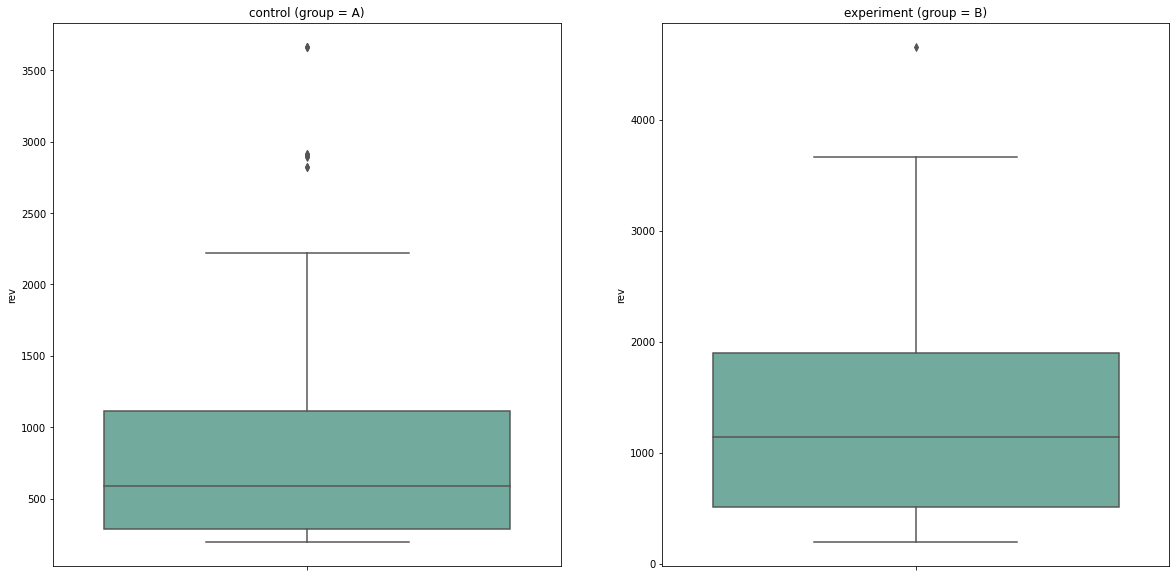

In [273]:
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(20)
fig.set_figheight(10)

sns.boxplot(data=grA_with_checks, y = 'rev', ax=axs[0])
axs[0].set_title('control (group = A)')
sns.boxplot(data=grB_with_checks, y = 'rev', ax=axs[1])
axs[1].set_title('experiment (group = B)')

Text(0.5, 1.0, 'experiment (group = B)')

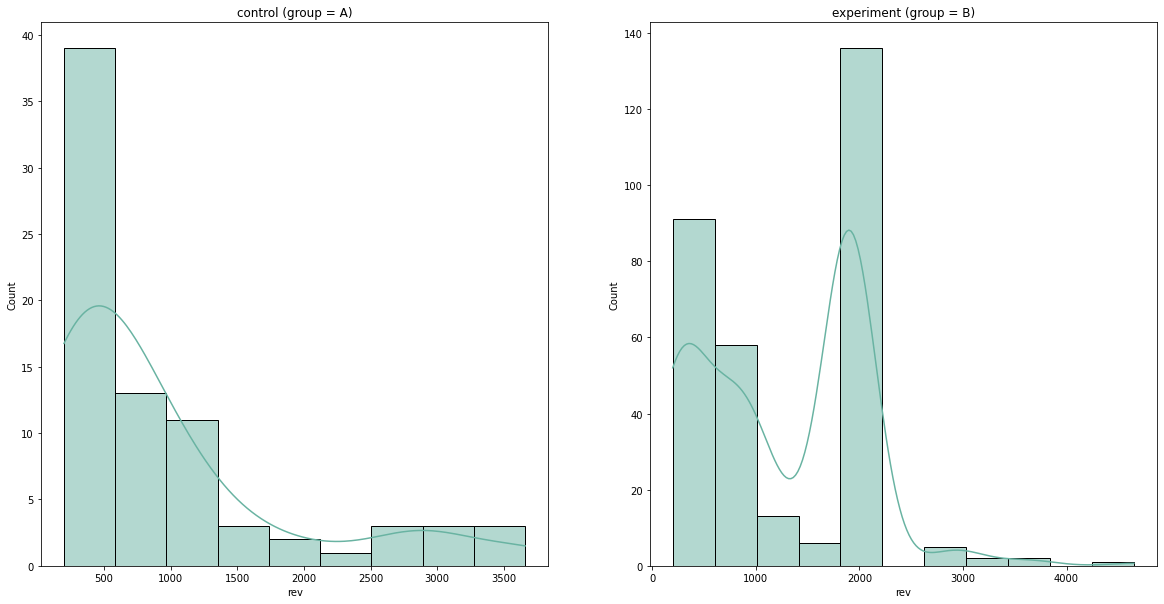

In [274]:
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(20)
fig.set_figheight(10)

sns.histplot(data=grA_with_checks, x='rev', kde=True, ax=axs[0])
axs[0].set_title('control (group = A)')
sns.histplot(data=grB_with_checks, x='rev', kde=True, ax=axs[1])
axs[1].set_title('experiment (group = B)')

* Проведем тест на нормальность распределения с помощью библиотеки **scipy**:

In [275]:
ss.normaltest(grA_with_checks.rev)

NormaltestResult(statistic=30.378419638487458, pvalue=2.531686880422046e-07)

In [276]:
ss.normaltest(grB_with_checks.rev)

NormaltestResult(statistic=6.795662714490353, pvalue=0.033445723194625424)

* Проведем тест на равенство дисперсий с помощью теста Левена:

In [277]:
ss.levene(grA_with_checks.rev, grB_with_checks.rev)

LeveneResult(statistic=3.0756816999816055, pvalue=0.08025675761347022)

<b> Выводы по итогам исследования данных о платежах: </b>
* Средние значения чеков в тестовой группе больше, чем в контрольной;
* Распределения суммы чеков в наших являются ненормальными. Это видно из графиков и стат. тесты подтверждают это (p-value < 0.05);
* Дисперсии суммы платежей не имеют значимых различий (p-value > 0.05) 

Будем сравнивать средние значения суммы платежей. Можем ли мы применить т-критерий Стьюдента для наших выборок, учитывая, что они не имеют нормального распределения? 

Нормальность данных критична только для очень маленьких выборок (примерный ориентир – меньше 30). У нас выборки больше 30 записей в каждой, поэтому т-тест будет работать корректно. Тест должен быть параметрическим, т.к. все параметры выборки нам известны.

Плюс мы знаем, что дисперсии наших выборок равны. Поэтому для сравнения средних значений доли мэтчей между двумя группами будем использовать <u>т-критерий Стьюдента</u> для наших несвязанных выборок, где:</i>
* <b><font color='red'> $H_0$ (нулевая гипотеза) говорит, о том что средние значения не отличаются;</font></b>

* <b><font color='green'> $H_1$ (альтернативная гипотеза) говорит, о том что средние значения в выборках отличаются.</font></b>

Если рассчитанное p-value будет меньше 0.05, можно будет отвергнуть нулевую гипотезу.

* Произведем расчеты т-теста разными библиотеками: 

In [279]:
pg.ttest(grA_with_checks.rev, 
         grB_with_checks.rev,
         correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.13378,390,two-sided,0.001856,"[-527.74, -120.84]",0.39646,14.001,0.878211


In [280]:
ss.ttest_ind(grA_with_checks.rev, 
             grB_with_checks.rev,
             equal_var=True)

Ttest_indResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867)

*p-value равное 0.0018 (< 0.05) говорит нам, что мы можем отвергнуть нулевую гипотезу и сделать вывод, что <font color='green'>средний чек между двумя группами статистически различается.</font>* 

*Отрицательное значение переменной т-статистики говорит нам о том, что значения среднего чека в экспериментальной группе выше, чем в контрольной.*

# <font color='blue'> Аналитическое заключение проведенного анализа данных </font>

<i>Сравнив контрольную и экспериментальную (тестовую) группы по конверсии в покупку и среднему чеку можно сделать следующий вывод.</i>

* Эксперимент показал, что конверсии в покупку у тестовой и контрольной группы стат. значимо не различаются. Поэтому новая механика оплаты услуг в данном эксперименте видимых улучшений не принесла. Возможно стоит что-то доработать в новой системе, а возможно эксперимент по другому выстроить, к примеру, сделать однородным кол-во пользователей в тестовой и контрольной группах (в нашем эксперименте все-таки в тестовой группе пользователей было значительно больше). 

* Средний чек в экспериментальной группе стат. значимо выше чем в контрольной. Но это не может являться основанием для утверждения, что этот результат связан с новой механикой оплаты.

<b>Резюме: <p><font color='red'>> Предлагаем пока не "раскатывать" новую механику оплаты на всех пользователей</font></b></p>

# Задача № 2. Образовательные курсы.

2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

2.1.2 Задача

Дана таблица default.peas.

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

* Сначала напишем SQL-запрос в Redash, а потом переведем его в Jupyter (используем pandahouse). Основным будет добавление в having условия на 20 правильных ответов.

In [35]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [36]:
query = '''
select count(distinct st_id) as count_diligent_students
from
(select st_id, toStartOfMonth(timest) as month, sum(correct) as count_peas
from default.peas
where correct = 1
group by st_id, month
having count_peas >= 20)
'''

In [37]:
ph.read_clickhouse(query=query, connection=connection_default)

,count_diligent_students
0,136


## <font color='blue'> У нас из 308 студентов 136 усердных учеников (44%) </font>

2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2.2 Задача

Даны таблицы: default.peas (см. выше), default.studs и default.final_project_check.

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

* ARPU 
* ARPAU 
* CR в покупку 
* СR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

* Тут придется применять left join 2 таблиц по 2 раза. Один джоин для всех студентов, другой для студентов курса по математике:

In [38]:
query = '''
select  
studs.test_grp as grp,
        count(distinct studs.st_id) as Users,
        round(sum(checks.money) / count(distinct studs.st_id), 2) as ARPU,
        round(sum(checks.money) / count(distinct active_studs.st_id), 2) as ARPAU,
        round(count(distinct checks.st_id) / count(distinct studs.st_id), 2) as CR_in_purchase,
        round(count(distinct checks.st_id) / count(distinct active_studs.st_id), 2) as CR_in_purchase_active_users,
        round(count(distinct math_checks.st_id) / count(distinct active_studs_math.st_id), 2) as CR_in_purchase_math_users
from default.studs as studs
    left join default.final_project_check as checks ON studs.st_id = checks.st_id
    left join (select st_id from default.final_project_check where subject ='Math') as math_checks ON studs.st_id = math_checks.st_id
    left join (select st_id, sum(correct) as count_peas from  default.peas where correct = 1 group by st_id having count_peas > 10) as active_studs ON studs.st_id = active_studs.st_id
    left join (select st_id, sum(correct) as count_peas from  default.peas where correct = 1 and subject = 'Math' group by st_id having count_peas >= 2) as active_studs_math ON studs.st_id = active_studs_math.st_id

group by grp
'''

In [39]:
ph.read_clickhouse(query=query, connection=connection_default)

,grp,Users,ARPU,ARPAU,CR_in_purchase,CR_in_purchase_active_users,CR_in_purchase_math_users
0,control,305,4540.98,10820.31,0.05,0.12,0.18
1,pilot,295,11508.47,35000.00,0.11,0.34,0.40


## <font color='blue'> Здесь тестовая группа по всем наблюдаемым метрикам имеет более высокие значения, чем контрольная. Однако для определения значимости различий необходимо применить статистические методы. А это совсем другая история, а точнее, другая задача... </font>

# Задача № 3. Автоматизация подгрузки данных

3.1 Задача

1. Реализовать функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.


2. Реализовать функцию, которая будет строить графики по получаемым метрикам.


## <font color='blue'> Немного рассуждений по плану действий </font>
*Дополним это задание информацией из задачи № 1.*

*Представим, условия задачи № 1 изменились. Дополнительный файл с пользователями и их группами - динамический, т.е. он может изменяться по составу пользователей (при этом названия колонок могут меняться, но порядок и кол-во колонок неизменно). Требуется подгружать информацию из этого файла и пересчитывать метрики. Предлагаю, исходя из имеющихся данных, рассчитывать две метрики: ARPU и CR в покупку. При чем, отдельно считать по всем пользователям и по активным пользователям - для этого заведем отдельный параметр для функции.*

*Важный момент. Мы договариваемся, что остальные 3 файла неизменны: groups, checks, active_studs.*

*Плюс создадим функцию отрисовки двух вертикальных барплотов по рассчитанным метрикам.*

In [40]:
'''
функция пересчета ARPU и CR в покупку
входные параметры:
1. groups_add_file - путь к доп. файлу на Яндекс диске, к примеру, groups_add_file='https://disk.yandex.ru/d/5Kxrz02m3IBUwQ';
2. active - если True, расчет производить по активным пользователям (которые посетили платформу во время эксперимента);
            если False, расчет производится по всем пользователям, имеющихся в наших данных.
            
ARPU = выручка / кол-во всех пользователей
CR в покупку = кол-во пользователей с покупками / кол-во всех пользователей
'''
def recalc_metrics(groups_add_file, active=True): 
    groups_add = pd.read_csv(url_from_yandex_disk(groups_add_file)) # считываем файл
    groups_add = groups_add.rename(columns={groups_add.columns[0]: 'id', groups_add.columns[1]: 'grp'}) # переименовываем колонки для дальнейшей работы
    
    groups_add = pd.merge(groups, groups_add, how='left') # объединяем с основным файлом пользователей
    if active: # если True, определяем только тех пользователей, кто заходил на платформу
        users = pd.merge(active_studs, groups_add, how='inner', left_on='student_id', right_on='id').drop(['id'], axis=1)
        users = pd.merge(users, checks, how='left', on='student_id') # добавляем информацию об оплате
        arpu_name = 'ARPAU'
        cr_name = 'CR_in_purchase_active_users'
    else: # если False, берем всех пользователей из наших файлов, не объединяя с зашедшими на платформу
        users = groups_add.rename(columns={'id': 'student_id'})
        users = pd.merge(users, checks, how='left', on='student_id')
        arpu_name = 'ARPU'
        cr_name = 'CR_in_purchase'
    
    
    metrics = (
                users.groupby('grp', as_index=False)  # группируем по группе пользователей
                   .agg({'student_id': pd.Series.nunique, 'rev': 'sum'})  # считаем кол-во уникальных пользователей и сумму выручки
                   .rename(columns={'student_id': 'all_users'}) 
                   .round(0)
              )
        
    with_checks = (
                    users[users.rev.isna() == False].groupby('grp', as_index=False)  # отдельно группируем данные по клиентам (что-то купили)
                                                    .agg({'student_id': pd.Series.nunique}) 
                                                    .rename(columns={'student_id': 'users_with_checks'})
                  )
        
    metrics = pd.merge(metrics, with_checks, how='inner', on='grp') # объединяем сгруппированные данные
    metrics[arpu_name] = round(metrics['rev'] / metrics['all_users'], 2) # расчет ARPU
    metrics[cr_name] = round(metrics['users_with_checks'] / metrics['all_users'], 2) # расчет CR в покупку
    
    return metrics

In [41]:

groups = pd.read_csv(url_from_yandex_disk('https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep=';')
active_studs = pd.read_csv(url_from_yandex_disk('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'))
checks = pd.read_csv(url_from_yandex_disk('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep=';')


calculated_metrics = recalc_metrics(groups_add_file='https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', active=True)
calculated_metrics

,grp,all_users,rev,users_with_checks,ARPAU,CR_in_purchase_active_users
0,A,1535,72820.0,78,47.44,0.05
1,B,6793,393074.0,313,57.86,0.05


In [42]:
'''
функция построения графиков (барплотов) ARPU и CR в покупку
входные параметры:
1. df - датафрейм, где первая колонка = названия групп, вторая = значения ARPU, третья = значения CR;
'''
def show_plots(df):
    fig, axs = plt.subplots(ncols=2)
    fig.set_figwidth(15)
    fig.set_figheight(7)
    
    plt.suptitle('Metrics in A/B test')
    colors = ["#69b3a2", "#4374B3"]
    sns.set_palette(sns.color_palette(colors))

    sns.barplot(data=df, x=df.columns[0], y=df.columns[1], ax=axs[0])
    sns.barplot(data=df, x=df.columns[0], y=df.columns[2], ax=axs[1])

    axs[0].set_title(df.columns[1], fontsize=18, pad=10)
    axs[0].set(ylabel=None)
    axs[0].set(xlabel='Group')
    for p in axs[0].patches: # добавляем значения над столбцами
        axs[0].annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='top', fontsize=10, color='gray', xytext=(10, 15),
                        textcoords='offset points')

    axs[1].set_title(df.columns[2], fontsize=18, pad=10)
    axs[1].set(ylabel=None)
    axs[1].set(xlabel='Group')
    for p in axs[1].patches:
        axs[1].annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='top', fontsize=10, color='gray', xytext=(10, 15),
                        textcoords='offset points')

    plt.subplots_adjust(wspace = 0.3)
    plt.show()

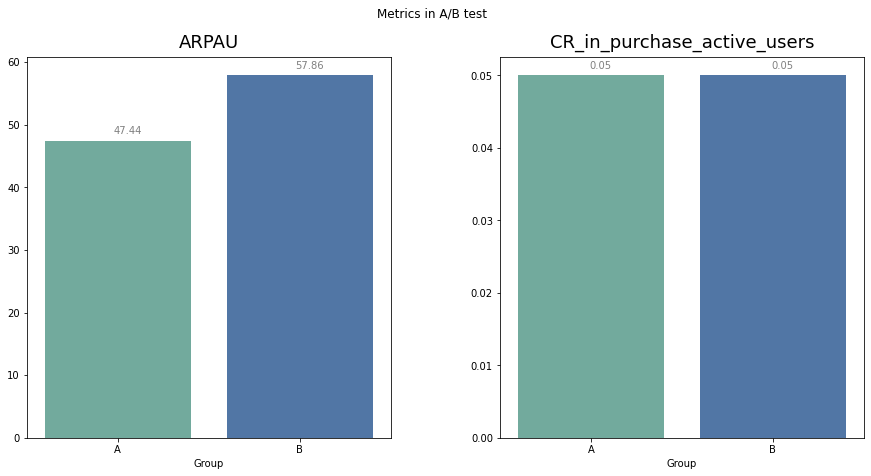

In [43]:
show_plots(calculated_metrics.iloc[:,[0,4,5]])